In [10]:
import numpy as np
import nibabel as nib
import os
import re
from rsatoolbox.inference import eval_fixed
from rsatoolbox.model import ModelFixed
from rsatoolbox.util.searchlight import get_volume_searchlight, get_searchlight_RDMs, evaluate_models_searchlight
from nilearn.image import load_img
from nilearn import plotting
from rsatoolbox.rdm import RDMs
import matplotlib.pyplot as plt
from nilearn.image import new_img_like
import seaborn as sns
import rsatoolbox.rdm as rsr
import rsatoolbox.data as rsd
import rsatoolbox

In [2]:
subjects = ['sub-01']
task_halves = ['1', '2']
RDM_version = '01'
no_RDM_conditions = 80

In [5]:
sub = 'sub-01'
task_half = '1'
data_dir = f"/Users/xpsy1114/Documents/projects/multiple_clocks/data/derivatives/{sub}"
RDM_dir = f"{data_dir}/beh/RDMs_{RDM_version}"

In [6]:
fmri_data_dir = f"{data_dir}/func/preproc_clean_0{task_half}.feat"
file = "example_func.nii.gz"
ref_img = load_img(f"{fmri_data_dir}/{file}")
x, y, z = ref_img.get_fdata().shape
ref_img = ref_img.get_fdata()


# Prepare searchlight positions
mask = load_img(f"/Users/xpsy1114/Documents/projects/multiple_clocks/data/derivatives/{sub}/func/mask_0{task_half}_mask.nii.gz")
mask = mask.get_fdata()

In [8]:
# this doesnt work with spyder.
# plotting.view_img(mask, cmap='gray', title='Brain Mask')
centers, neighbors = get_volume_searchlight(mask, radius=3, threshold=0.5)


pe_path = f"/Users/xpsy1114/Documents/projects/multiple_clocks/data/derivatives/sub-01/func/glm_04_pt0{task_half}.feat/stats"

# Loop through files in the folder
# define the naming conventions in this folder
pes_I_want = re.compile(r'^pe([1-9]|[1-7][0-9]|80)\.nii\.gz$')
# List all files in the folder
files_in_pe_folder = os.listdir(pe_path)

# loop over all images
data_RDM_file = np.zeros((no_RDM_conditions, x, y, z))

# Loop through the files and read in only those that match the pattern
image_paths = []
i = 0
for filename in files_in_pe_folder:
    if pes_I_want.match(filename):
        file_path = os.path.join(pe_path, filename)
        image_paths.append(os.path.join(file_path, filename))  # Get the full file path
        data_RDM_file[i] = nib.load(file_path).get_fdata()
        i += 1

Finding searchlights...: 100%|██████████████████████████████████████████████████████| 162061/162061 [00:07<00:00, 21587.80it/s]


Found 160229 searchlights


In [9]:
# STEP 2: get RDM for each voxel
# reshape data so we have n_observastions x n_voxels
data_RDM_file_2d = data_RDM_file.reshape([data_RDM_file.shape[0], -1])
data_RDM_file_2d = np.nan_to_num(data_RDM_file_2d) # now this is 80timepoints x 153594 voxels

# only one pattern per image
image_value = np.arange(len(image_paths))

# Get RDMs
data_RDM = get_searchlight_RDMs(data_RDM_file_2d, centers, neighbors, image_value, method='correlation')

Calculating RDMs...: 100%|███████████████████████████████████████████████████████████████████| 100/100 [02:13<00:00,  1.34s/it]


In [11]:
# then load the data RDMs. 
location_data_RDM = np.load(os.path.join(RDM_dir, f"RSM_location_{sub}_fmri_pt{task_half}.npy"))
clocks_data_RDM = np.load(os.path.join(RDM_dir, f"RSM_clock_{sub}_fmri_pt{task_half}.npy"))
midnight_data_RDM = np.load(os.path.join(RDM_dir, f"RSM_midnight_{sub}_fmri_pt{task_half}.npy"))
phase_data_RDM = np.load(os.path.join(RDM_dir, f"RSM_phase_{sub}_fmri_pt{task_half}.npy"))

# load the data files in case I want to use these instead.
location_data = np.load(os.path.join(RDM_dir, f"data_location_{sub}_fmri_pt{task_half}.npy"))
clocks_data = np.load(os.path.join(RDM_dir, f"data_clock_{sub}_fmri_pt{task_half}.npy"))
midnight_data = np.load(os.path.join(RDM_dir, f"data_midnight_{sub}_fmri_pt{task_half}.npy"))
phase_data = np.load(os.path.join(RDM_dir, f"data_phase_{sub}_fmri_pt{task_half}.npy"))

In [12]:
# from here this is only copied from the tutorial
location_data = location_data.transpose()
nCond = location_data.shape[0]
nVox = location_data.shape[1]
des = {'session': 1, 'subj': 1}
obs_des = {'conds': np.array(['cond_%02d' % x for x in np.arange(nCond)])}
chn_des = {'voxels': np.array(['voxel_' + str(x) for x in np.arange(nVox)])}
data = rsd.Dataset(measurements=location_data,
                   descriptors=des,
                   obs_descriptors=obs_des,
                   channel_descriptors=chn_des)

In [14]:
# make the location model from the location RDM object
loc_RDM = rsr.calc_rdm(data, method='correlation')
fig, ax, ret_vla = rsatoolbox.vis.show_rdm(loc_RDM)
loc_model = rsatoolbox.model.ModelFixed('test', loc_RDM)


Evaluating models for each searchlight: 100%|████████████████████████████████████████| 160229/160229 [01:45<00:00, 1522.39it/s]
/var/folders/h2/_86s79551w1734r87y2wlkk40000gt/T/ipykernel_63937/62328009.py:4: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  eval_score = [np.float(e.evaluations) for e in eval_results]


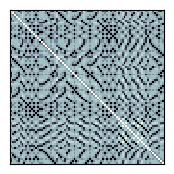

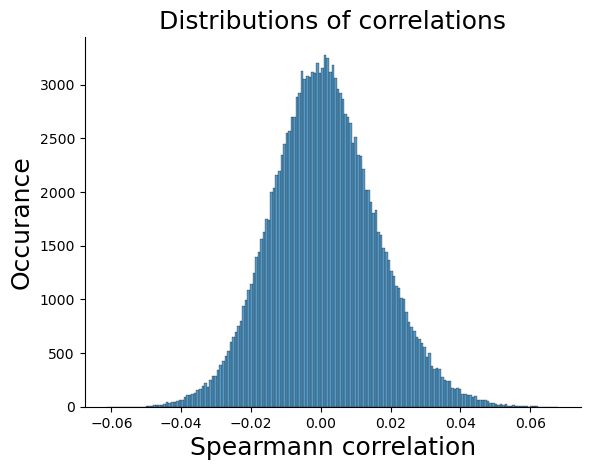

In [15]:
eval_results = evaluate_models_searchlight(data_RDM, loc_model, eval_fixed, method='spearman', n_jobs=3)
# get the evaulation score for each voxel
# We only have one model, but evaluations returns a list. By using float we just grab the value within that list
eval_score = [np.float(e.evaluations) for e in eval_results]
# Create an 3D array, with the size of mask, and
x, y, z = mask.shape
RDM_brain = np.zeros([x*y*z])
RDM_brain[list(data_RDM.rdm_descriptors['voxel_index'])] = eval_score
RDM_brain = RDM_brain.reshape([x, y, z])

plt.figure()
sns.histplot(eval_score)
plt.title('Distributions of correlations', size=18)
plt.ylabel('Occurance', size=18)
plt.xlabel('Spearmann correlation', size=18)
sns.despine()
plt.show()

In [19]:
# lets plot the voxels above the 99th percentile
ref_img = load_img(f"{fmri_data_dir}/{file}")
threshold = np.percentile(eval_score, 99)
plot_img = new_img_like(ref_img, RDM_brain)

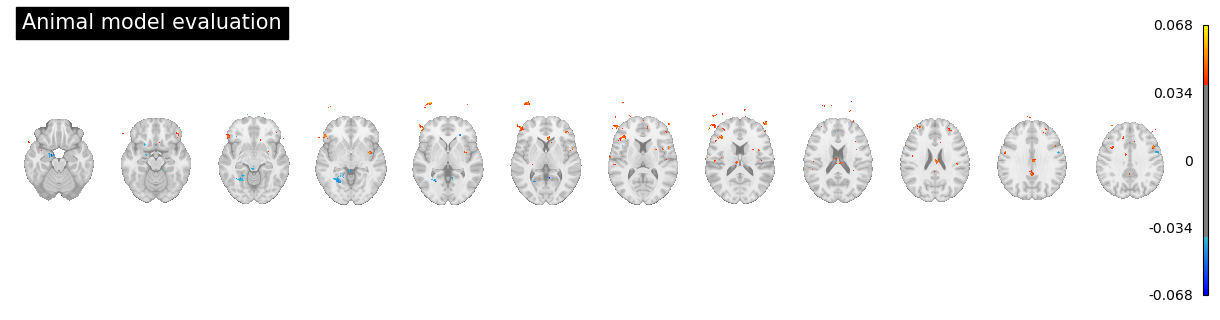

In [20]:
# define this
import matplotlib.colors
def RDMcolormapObject(direction=1):
    """
    Returns a matplotlib color map object for RSA and brain plotting
    """
    if direction == 0:
        cs = ['yellow', 'red', 'gray', 'turquoise', 'blue']
    elif direction == 1:
        cs = ['blue', 'turquoise', 'gray', 'red', 'yellow']
    else:
        raise ValueError('Direction needs to be 0 or 1')
    cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", cs)
    return cmap


cmap = RDMcolormapObject()

coords = range(-20, 40, 5)
fig = plt.figure(figsize=(12, 3))

display = plotting.plot_stat_map(
        plot_img, colorbar=True, cut_coords=coords,threshold=threshold,
        display_mode='z', draw_cross=False, figure=fig,
        title=f'Animal model evaluation', cmap=cmap,
        black_bg=False, annotate=False)
plt.show()